The below cells of code are used to create a Logistic Regression model to predict if a flight out of an aiport with the US will be delayed or not. The first cell of code imports needed packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)

After importing the merged file, airline_merged.csv, that was created in the ipynb file, airline_files_merge, we needed to remove the addditional column(Unnamed: 0) that is added in the export. 

In [4]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

The below cell creates a correlation matrix using all of the numerical columns and removes any column that has a correlation coeffecient that is greater than 0.90. This will eventually help decrease the amount of columns that are used in the model and help with any assumptions that need to be met.

In [5]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_7420/4014107192.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [6]:
#looking at dataframe after removing highly correlated fields.
df.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,5,-11.0,21.0,205.0,404.0,4.0,430,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,10,-8.0,12.0,280.0,737.0,4.0,750,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,20,-2.0,16.0,286.0,800.0,11.0,806,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,20,-5.0,15.0,285.0,748.0,8.0,805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,25,-1.0,11.0,235.0,254.0,5.0,320,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Since the data set is quite large and personal laptops will struggle to churn through the amount of rows and columns, we decided to filter down the data to Dallas-Fort Worth International Airport. This decreased the data frame size from almost 6 million rows to just under 240k rows and also helped with the one hot encoding below.

In [7]:
#selecting 5 busiest airports in US
#airports = ['ATL','DFW','ORD','LAX','DEN']
airports = ['DFW']

In [8]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [9]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,239551.0,239551.000000,239551.000000,239551.000000,239551.000000,2.395510e+05,2.395510e+05,239551.000000,239551.000000,239551.000000,233658.000000,233383.000000,239551.000000,233177.000000,233177.000000,239551.000000,239551.000000,239551.000000,50478.000000,50478.000000,50478.000000,50478.000000,50478.000000
mean,2015.0,6.064788,15.644890,3.945598,1999.527111,3.289595e+01,-9.703720e+01,35.454168,-95.072603,1406.443325,11.528820,17.242344,134.791293,1556.667347,6.466109,1579.647649,0.002713,0.026107,10.543623,0.113000,21.174888,20.654245,5.074389
std,0.0,3.392869,8.784501,1.996657,1155.423485,1.391814e-10,1.210625e-10,5.164937,14.372262,458.043842,36.308279,8.543331,60.350783,507.568388,5.213076,487.907272,0.052020,0.159454,22.054115,2.274275,39.279341,39.726000,24.350348
min,2015.0,1.000000,1.000000,1.000000,4.000000,3.289595e+01,-9.703720e+01,18.439420,-157.922410,140.000000,-28.000000,1.000000,33.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1164.000000,3.289595e+01,-9.703720e+01,31.611290,-103.057370,1025.000000,-4.000000,13.000000,84.000000,1155.000000,4.000000,1206.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2214.000000,3.289595e+01,-9.703720e+01,35.214010,-93.825600,1400.000000,-1.000000,15.000000,133.000000,1555.000000,5.000000,1604.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000
75%,2015.0,9.000000,23.000000,6.000000,2810.000000,3.289595e+01,-9.703720e+01,39.858410,-84.426940,1820.000000,11.000000,19.000000,170.000000,1950.000000,7.000000,1959.000000,0.000000,0.000000,15.000000,0.000000,27.000000,26.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6529.000000,3.289595e+01,-9.703720e+01,61.174320,-66.001830,2359.000000,1377.000000,225.000000,523.000000,2400.000000,197.000000,2359.000000,1.000000,1.000000,664.000000,190.000000,942.000000,1331.000000,862.000000


In [10]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

Because we want to predict if an airplane is going to be delayed or not using logistic regression, we created a new field called "is_delay" from the "departure_delay" field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

In [11]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

/var/folders/cn/_lgzxbk177j14_b82nbl10br0000gn/T/ipykernel_7420/3939397851.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)


After creating the "is_delay" field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 250k by 42 data set to become 240k by 3400. 

In [12]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [13]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

#head(final_df)

Once the target variable was created and we one hot encoded the data set, we were able to begin modeling our data. To start, we separated the features with the target varibale as to not leave the response in a test or train data set.

In [14]:
#remove target variable and column target was created from training data set
target_cols = ['is_delay','departure_delay']
feature_cols = final_df.loc[:, ~final_df.columns.isin(target_cols)].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

From sklearn, we used their train_test_split package to create a 75/25 train and test split for our model.

In [15]:
#split dataset in features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

After one hot encoding, for our logistic regession model to run, we imputed the NaN values with 0.

In [16]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [17]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (179663, 3396) 

X_test shape:  (59888, 3396) 

y_train shape:  (179663,) 

y_test shape:  (59888,)


To simplify the code and useability of the model, we used a pipeline function from sklearn to standardize (using StandarScaler), run the data through PCA and then finally a logistic regession model using the PCA output. 

In [18]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

njobs = -1
tolerance = 0.1
l1ratio = 1
rs = 0

# Scale -> PCA -> LR 
logistic = LogisticRegression(solver = 'saga',
                                random_state = rs,
                                penalty ='elasticnet',
                                l1_ratio = l1ratio,
                                tol = tolerance)

pipe = Pipeline(steps=[("scaler", scaler),
                       ("pca", pca),
                       ("logistic", logistic)]
               )

pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()),
                ('logistic',
                 LogisticRegression(l1_ratio=1, penalty='elasticnet',
                                    random_state=0, solver='saga', tol=0.1))])

After fitting the model, we then ran our test data set through to create predictions.

In [19]:
#predict
y_pred=pipe.predict(X_test)

After creating predictions on our test data set, we pulled metrics to determine how well our model performed. Our base model had an accuracy of 78.31% with a precision of 95.99% and a recall of 51.54%. This model output gives us a good starting point for hypertuing the model and comparison against some more powerful models such as XGBoost or LightGBM. After computing these metrics we then created a confusion matrix heatmap to better visualize how well our model was predicting and where the model could perform better with False Positives and False Negatives.

In [20]:
#Metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7397976222281593
Precision: 0.9044354838709677
Recall: 0.43786358489829386


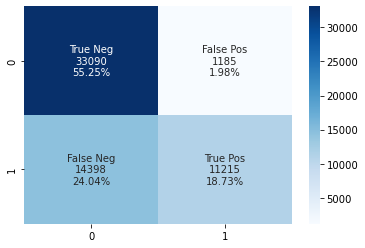

In [21]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

Finally we chose to plot a ROC curve to visualize specificity and sensitiviy of our model. 

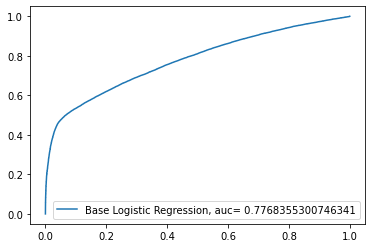

In [22]:
#ROC Curve
y_pred_proba = pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(auc))
plt.legend(loc=4)
plt.show()

# SVM Model
#### _SVC Package from Sklearn_


**_Accuracy_:**


In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
import time


#set up SVC model model
#clf = SVC(kernel='linear')

#fit model
#clf.fit(X_train,y_train)

#predict model
#y_pred = clf.predict(X_test)

#check accuracy
#accuracy = accuracy_score(y_test,y_pred)
#print(accuracy)


#baggingclassifier

n_estimators = 10
start = time.time()
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel = 'linear',class_weight = 'balanced'), max_samples = 1.0 / n_estimators, n_estimators = n_estimators))
clf.fit(X_train,y_train)
end = time.time()
clf.predict(X_test)
accuaracy = accuracy_score(y_test,y_pred)
print('Runtime:',end-start)
print('Accuracy:',accuaracy)

NameError: name 'accuracy_score' is not defined